# Решение OpenDataBattle от Банка Открытие
### Как не делая ничего занять топ 43%

---
#### Задача
Научиться минимизировать ошибку другой (классификационной) модели и сделать предсказание. Модель предсказывала вероятность дефолта по кредиту для клиента. Модель выдавала только 0 или 1, а настоящая вероятность находится в интервале между 0 и 1. Следовательно, необходимо научиться предсказывать разницу между предсказанием модели и правильным ответом (флагом) 

Дано:
- датасет `data.csv` (почти 2к признаков) - данные клиента
- результат предсказания некой модели столбец PD в `model.csv` (вероятность объекта быть классом 1 - вероятность дефолта)
- правильный ответ вероятности (флаг) - `flg_90_12_add`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
df = pd.read_csv('/content/drive/MyDrive/odb/data.csv')

In [4]:
pred_res = pd.read_csv('/content/drive/MyDrive/odb/model.csv')

### Несколько важных функций для работы

In [5]:
def all_data_transformation(df, feature_nan_proc=0.5):
    
    def transform_function(frame):
        frame = frame.copy()

        frame.drop(['incident'], inplace=True, axis=1)
        frame.drop(['flg_90_12_add'], inplace=True, axis=1)
        frame.drop(['APPLICATION_MONTH'], inplace=True, axis=1)

        return frame
    
    to_drop = []
    for column in df.columns[3:]:
        if (df[column].isnull().sum() - 1000)/df.shape[0] > feature_nan_proc:
            to_drop.append(column)
    
    df.drop(to_drop, inplace=True, axis=1)
    
    df.fillna(df.mean(), inplace=True)
    
    work_df = df[:-1000].copy()
    valid_df = df[-1000:].copy()

    work_target = work_df['flg_90_12_add'].copy() - pred_res['PD'][:-1000].copy()
    work_target = np.abs(work_target)
    
    work_df = transform_function(work_df)
    
    # TOO MUCH ROWS 
    work_df, _, work_target, _ = train_test_split(work_df, work_target, train_size=8000, random_state=17)
    train_data, test_data, train_target, test_target = train_test_split(work_df, work_target)
    
    valid_df = transform_function(valid_df)
    
    return train_data, test_data, train_target, test_target, valid_df


#### Что суммарно делает функция `all_data_transform` ?

Поочередно:

Сперва находим столбцы для удаления. Был использован очень простой критерий - если (примерно) больше половины (`feature_nan_proc=0.5`) строк данного столбца были nan-значения, он удалялся. Далее в почищенной таблице все оставшиеся nan-значения в строках заполнялись средним значением по столбцу.

Поскольку данные для проверки решения были присоединены в основной датасет и файл с предсказанием модели, то мы отрезаем их от тренировочного и помещаем в отдельный фрейм `valid_df`.

Из-за большого размера датасета было принято решение обучаться на небольшой выборке из него. Итого в `train_data` оказалось 6000 строк из 82 000 возможных. В данном случае это не имело сильного влияния на точность результата, а время обучения сильно сокращалось.

In [6]:
train_data, test_data, train_target, test_target, valid_df = all_data_transformation(df=df)

In [7]:
%%time
gbm = GradientBoostingRegressor(n_estimators=200, loss='lad',
                                       random_state=17, criterion='squared_error').fit(train_data, train_target)

CPU times: user 1min 6s, sys: 61 ms, total: 1min 6s
Wall time: 1min 6s


In [8]:
mean_absolute_error(test_target, gbm.predict(test_data)) # n_estimators=200, loss='lad', crit='se' gbm

0.06077665906157578

## Чего не было сделано ?
Небольшая работа над ошибками с помощью ноутбуков старших по лидерборду


### Нормирование целевой переменной

Для нормирования распределения целевого признака осуществляется взятие логарифма, что сглаживает начальное распределение признака

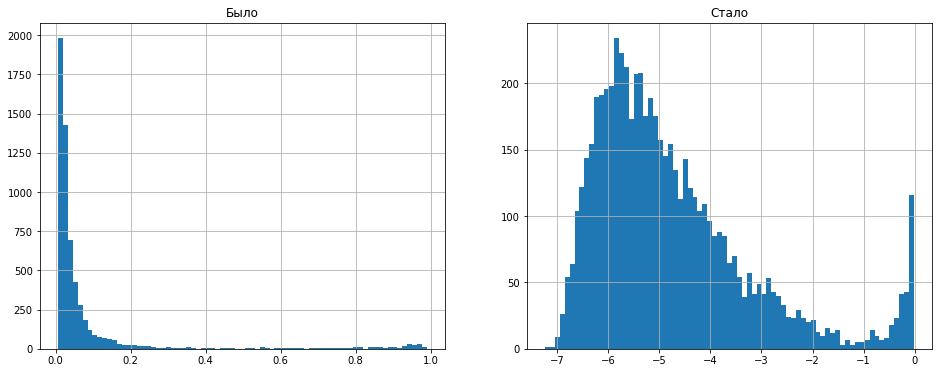

In [9]:
log_target = np.log2(train_target.copy())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].hist(train_target, bins=75)
ax[0].grid()
ax[0].set_title('Было')

ax[1].hist(log_target, bins=75)
ax[1].grid()
ax[1].set_title('Стало')
plt.show()

### Более грамотный просмотр использование фичей

Под этим имеется в виду, что несмотря на то что было выдано почти 2 тысячи признаков, можно было как минимум обратить внимание на просмотр "категориальных". Их было всего 18 штук.

Один из участников отметил , что распределение `Category_Feature_2` очень похоже на распределение возраста клиентов.

Также из замеченных пост-фактум идей участников пряглянулась такая - обучение разных моделей по группам данных. Например, разбиение всего датасета на 4 части (фолды) - по временам года, и обучить для каждого сезона модель и использовать их в конечном предсказании.

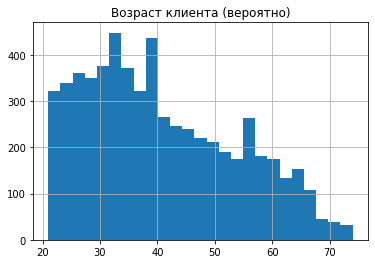

In [10]:
plt.hist(train_data['Category_Feature_2'], bins=25)
plt.title('Возраст клиента (вероятно)')
plt.grid()
plt.show()

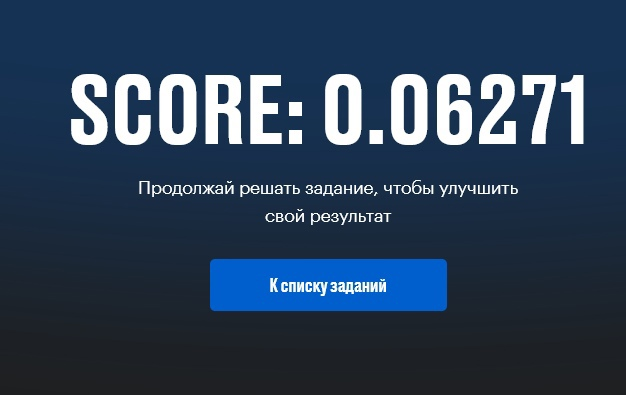

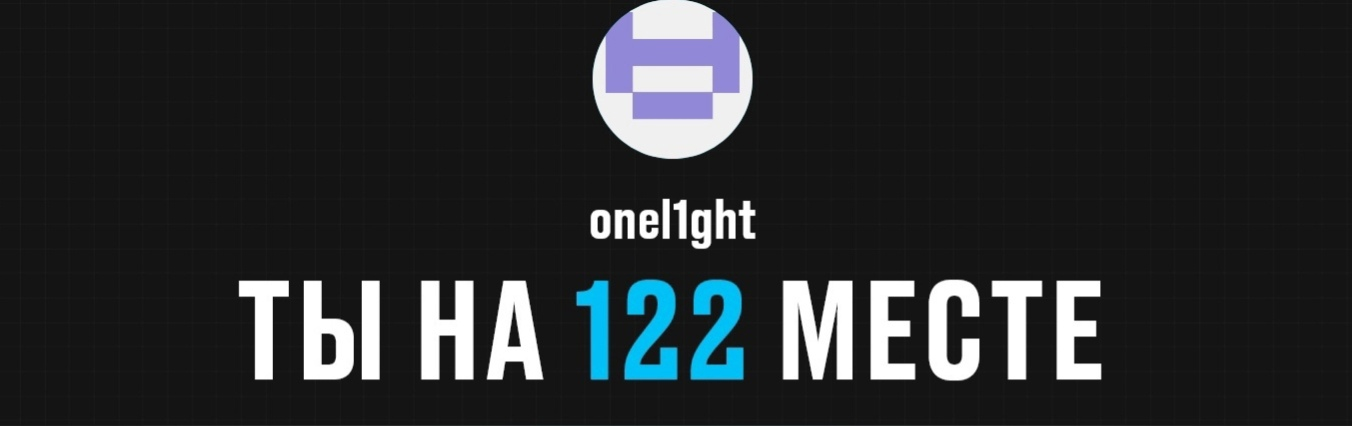